In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
data.shape

(35887, 3)

In [4]:
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [5]:
data.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [6]:

emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts().sort_index().reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Disgust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


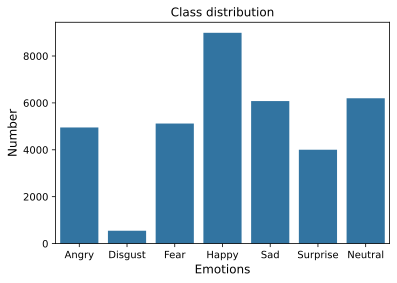

In [7]:

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6, 4))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

### 图片样本示例

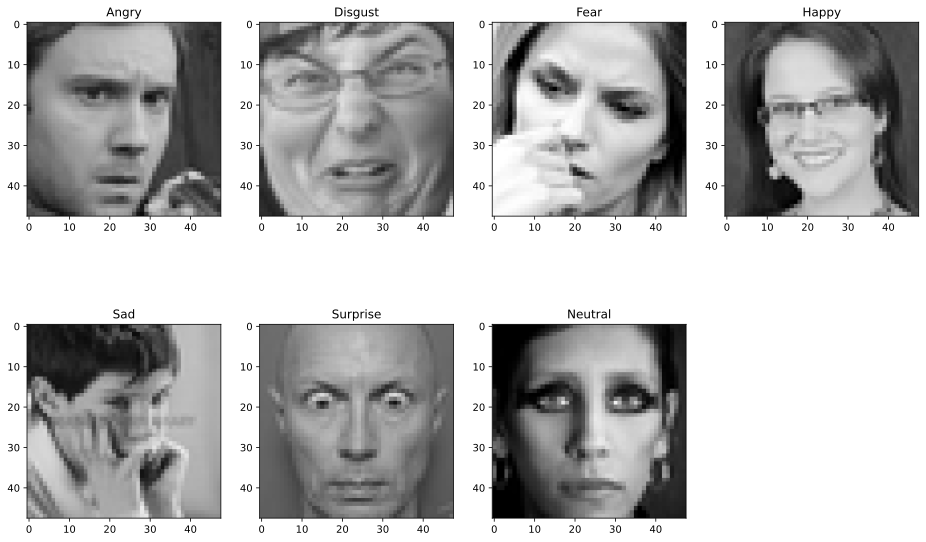

In [8]:
def row2image_label(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48, 48)
    image = np.zeros((48, 48, 3))
    image[:, :, 0] = img
    image[:, :, 1] = img
    image[:, :, 2] = img
    return image.astype(np.uint8), emotion

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(0, figsize=(16, 10))
for i in range(1, 8):
    face = data[data['emotion'] == i - 1].iloc[0]
    img, label = row2image_label(face)
    plt.subplot(2, 4, i)
    plt.imshow(img)
    plt.title(label)

plt.show()

In [9]:

data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()
print(f"train shape: {data_train.shape}")
print(f"validation shape: {data_val.shape}")
print(f"test shape: {data_test.shape}")

train shape: (28709, 3)
validation shape: (3589, 3)
test shape: (3589, 3)


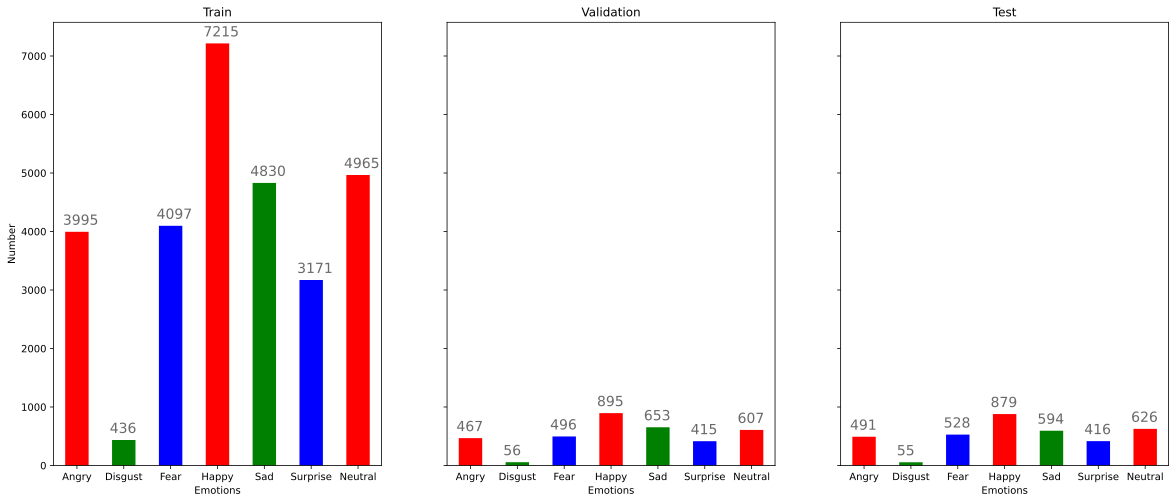

In [10]:

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


def setup_axe(axe, df, title):
    df['emotion'].value_counts().sort_index().plot(ax=axe, kind='bar', rot=0,
                                                   color=['r', 'g', 'b', 'r', 'g', 'b', 'r'])
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)


    for i in axe.patches:

        axe.text(i.get_x() - .05, i.get_height() + 120,
                 str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                 rotation=0)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey='all')
setup_axe(axes[0], data_train, 'Train')
setup_axe(axes[1], data_val, 'Validation')
setup_axe(axes[2], data_test, 'Test')
plt.show()

In [11]:

num_classes = 7
width, height = 48, 48
num_epochs = 10
batch_size = 128
num_features = 64
rate_drop = 0.1

In [12]:

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1, width, height, 1) / 255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, f"_X shape: {data_X.shape}, ", dataName, f"_Y shape: {data_Y.shape}")
    return data_X, data_Y


train_X, train_Y = CRNO(data_train, "train")  #training data
val_X, val_Y = CRNO(data_val, "val")  #validation data
test_X, test_Y = CRNO(data_test, "test")  #test data

train _X shape: (28709, 48, 48, 1),  train _Y shape: (28709, 7)
val _X shape: (3589, 48, 48, 1),  val _Y shape: (3589, 7)
test _X shape: (3589, 48, 48, 1),  test _Y shape: (3589, 7)


In [13]:
model = Sequential()

# ---------- Convolutional Stages 1 ----------
# ***** Conv Block a *****
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(width, height, 1),
                 data_format='channels_last', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# ***** Conv Block b *****
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---------- Convolutional Stages 2 ----------
# ***** Conv Block a *****
model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# ***** Conv Block b *****
model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---------- Convolutional Stages 3 ----------
# ***** Conv Block a *****
model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# ***** Conv Block b *****
model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---------- Convolutional Stages 4 ----------
# ***** Conv Block a *****
model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# ***** Conv Block b *****
model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())

# Full connection
model.add(Dense(4096, activation='relu', kernel_regularizer=l2()))
model.add(Dropout(rate_drop))
model.add(Dense(4096, activation='relu', kernel_regularizer=l2()))
model.add(Dropout(rate_drop))

#output layer
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2()))

model.compile(loss=['categorical_crossentropy'],
              optimizer=SGD(momentum=0.9, nesterov=True ),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0

In [14]:

data_generator = ImageDataGenerator(
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=10,
    featurewise_std_normalization=False,
    horizontal_flip=True)

es = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75, patience=5, verbose=1)

history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                    # steps_per_epoch=len(train_X) / batch_size,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    callbacks=[es, reduce_lr],
                    validation_data=(val_X, val_Y))

Epoch 1/10
225/225 - 35s - loss: 59.3044 - accuracy: 0.2593 - val_loss: 36.9388 - val_accuracy: 0.2494 - lr: 0.0100 - 35s/epoch - 156ms/step
Epoch 2/10
225/225 - 22s - loss: 24.7236 - accuracy: 0.2989 - val_loss: 16.0501 - val_accuracy: 0.2499 - lr: 0.0100 - 22s/epoch - 100ms/step
Epoch 3/10
225/225 - 23s - loss: 10.8392 - accuracy: 0.3528 - val_loss: 7.3000 - val_accuracy: 0.3483 - lr: 0.0100 - 23s/epoch - 101ms/step
Epoch 4/10
225/225 - 22s - loss: 5.2070 - accuracy: 0.4149 - val_loss: 3.9089 - val_accuracy: 0.3998 - lr: 0.0100 - 22s/epoch - 99ms/step
Epoch 5/10
225/225 - 23s - loss: 2.8971 - accuracy: 0.4608 - val_loss: 2.3601 - val_accuracy: 0.4572 - lr: 0.0100 - 23s/epoch - 100ms/step
Epoch 6/10
225/225 - 24s - loss: 1.9437 - accuracy: 0.4957 - val_loss: 1.7697 - val_accuracy: 0.4745 - lr: 0.0100 - 24s/epoch - 107ms/step
Epoch 7/10
225/225 - 22s - loss: 1.5347 - accuracy: 0.5223 - val_loss: 1.4527 - val_accuracy: 0.5060 - lr: 0.0100 - 22s/epoch - 99ms/step
Epoch 8/10
225/225 - 23s

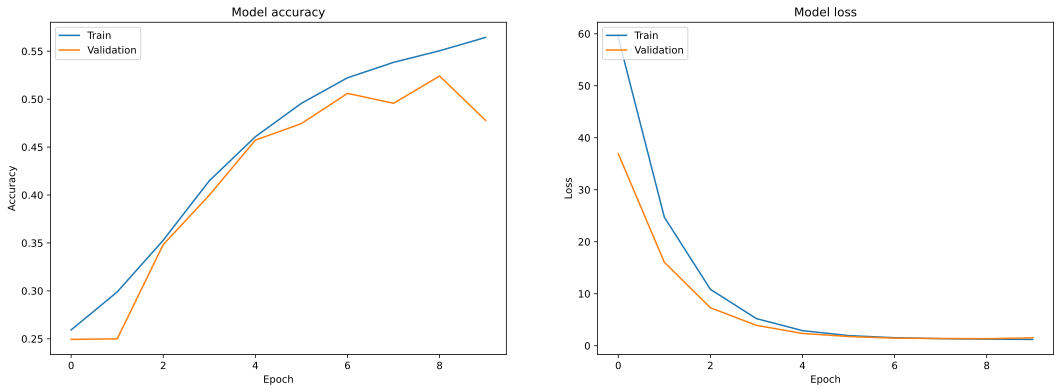

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 [==============================] - 2s 8ms/step
CNN Model Accuracy on test set: 0.4843


In [17]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'


    cm = confusion_matrix(y_true, y_pred)

    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

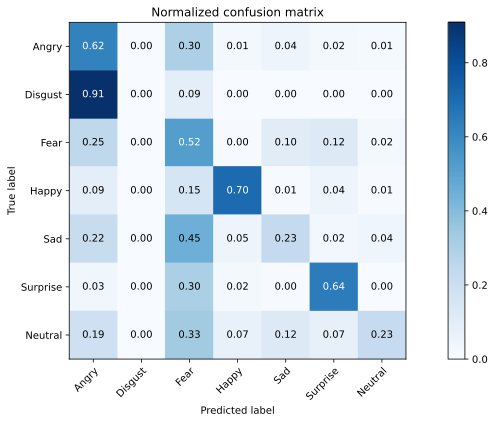

In [18]:

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [19]:
model.save('FER_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
